# PS1 Seam Carving — Fixed Notebook (Omar Khader)

In [1]:
# imports (keep these at the top)
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
# %matplotlib inline


In [9]:
## =========================
## Seam Carving Helper Funcs
## =========================
## required functions
# First we need to calculate the energy map of an input image.
# To do this we compute the intensity gradient in both x and y directions.
# Sobel / Prewitt are 3x3 operators we convolve over the image to get gradients.
# Then we turn gradients into energy per pixel via magnitude = sqrt(gx^2 + gy^2).
# Bonus: we penalize borders so seams do not hug the edges.

# Edge penalty (do not hug edges)
def add_edge_penalty(energy, penalty_strength=10.0):
  # Purpose: bump up energy near borders so the DP avoids picking seams on sides.
  M, N = energy.shape
  edge_width = max(5, int(0.015 * min(M, N)))
  mean_energy = float(np.mean(energy)) or 1.0
  x = np.arange(N); y = np.arange(M)
  X, Y = np.meshgrid(x, y)
  dist_from_left   = X
  dist_from_right  = N - 1 - X
  dist_from_top    = Y
  dist_from_bottom = M - 1 - Y
  dist_from_edge = np.minimum(np.minimum(dist_from_left, dist_from_right),
                              np.minimum(dist_from_top,  dist_from_bottom))
  penalty_map = np.zeros_like(energy, dtype=np.float64)
  mask = dist_from_edge < edge_width
  alpha = 3.0 / edge_width
  penalty_map[mask] = penalty_strength * mean_energy * np.exp(-alpha * dist_from_edge[mask])
  return energy.astype(np.float64) + penalty_map

# Simple gradient-based energy using numpy.gradient
def find_energy(image):
  # 1) must be RGB MxNx3
  assert image.ndim == 3 and image.shape[2] == 3
  # 2) to float in [0,1]
  imf = image.astype(np.float64) / 255.0
  # 3) grayscale via standard luminance
  grey = 0.299*imf[...,0] + 0.587*imf[...,1] + 0.114*imf[...,2]
  # 4) gradients
  gy, gx = np.gradient(grey)
  energy = np.sqrt(gx*gx + gy*gy)
  # 5) edge penalty
  energy = add_edge_penalty(energy, penalty_strength=10.0)
  return energy.astype(np.float64)

# Manual SAME convolution with reflect padding
def _pad_reflect(img, ph, pw):
  return np.pad(img, ((ph, ph), (pw, pw)), mode='reflect')

def _conv2d_same(gray, kernel):
  kh, kw = kernel.shape
  ph, pw = kh//2, kw//2
  padded = _pad_reflect(gray, ph, pw)
  H, W = gray.shape
  out = np.zeros_like(gray, dtype=np.float64)
  k = np.flipud(np.fliplr(kernel))
  for i in range(H):
    for j in range(W):
      patch = padded[i:i+kh, j:j+kw]
      out[i, j] = np.sum(patch * k)
  return out

def find_energy_sobel(image):
  assert image.ndim == 3 and image.shape[2] == 3
  imf = image.astype(np.float64)/255.0
  grey = 0.299*imf[...,0] + 0.587*imf[...,1] + 0.114*imf[...,2]
  sobel_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=np.float64)
  sobel_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=np.float64)
  gx = _conv2d_same(grey, sobel_x)
  gy = _conv2d_same(grey, sobel_y)
  energy = np.sqrt(gx*gx + gy*gy)
  energy = add_edge_penalty(energy, penalty_strength=10.0)
  return energy.astype(np.float64)

def find_energy_prewitt(image):
  assert image.ndim == 3 and image.shape[2] == 3
  imf = image.astype(np.float64)/255.0
  grey = 0.299*imf[...,0] + 0.587*imf[...,1] + 0.114*imf[...,2]
  prewitt_x = np.array([[-1,0,1],[-1,0,1],[-1,0,1]], dtype=np.float64)
  prewitt_y = np.array([[-1,-1,-1],[0,0,0],[1,1,1]], dtype=np.float64)
  gx = _conv2d_same(grey, prewitt_x)
  gy = _conv2d_same(grey, prewitt_y)
  energy = np.sqrt(gx*gx + gy*gy)
  energy = add_edge_penalty(energy, penalty_strength=10.0)
  return energy.astype(np.float64)

# Dynamic Programming cumulative map (paper)
def Cumulative_min_energy_map(energyImg, SD):
  assert energyImg.ndim == 2
  dir_up = SD.upper()
  if dir_up == 'VERTICAL':
    M, N = energyImg.shape
    Cumulative = np.zeros_like(energyImg, dtype=np.float64)
    Cumulative[0] = energyImg[0]
    for i in range(1, M):
      left  = np.r_[np.inf, Cumulative[i-1, :-1]]
      up    = Cumulative[i-1]
      right = np.r_[Cumulative[i-1, 1:], np.inf]
      best = np.minimum(np.minimum(left, up), right)
      Cumulative[i] = energyImg[i] + best
    return Cumulative
  if dir_up == 'HORIZONTAL':
    return Cumulative_min_energy_map(energyImg.T, 'VERTICAL').T
  raise ValueError("Direction must be 'VERTICAL' or 'HORIZONTAL'")

def find_vertical_seam(CumulativeEnergyMap):
  M, N = CumulativeEnergyMap.shape
  seam = np.zeros(M, dtype=np.int32)
  seam[-1] = int(np.argmin(CumulativeEnergyMap[-1]))
  for i in range(M-2, -1, -1):
    j = seam[i+1]
    j_left = max(j-1, 0)
    j_right = min(j+1, N-1)
    window = CumulativeEnergyMap[i, j_left:j_right+1]
    seam[i] = j_left + int(np.argmin(window))
  return seam

def find_horizontal_seam(CumulativeEnergyMap):
  return find_vertical_seam(CumulativeEnergyMap.T).astype(np.int32)

# Carving
def decrease_width(image, energyImg_in):
  Cumulative = Cumulative_min_energy_map(energyImg_in, 'VERTICAL')
  seam = find_vertical_seam(Cumulative)
  M, N, _ = image.shape
  out = np.zeros((M, N-1, 3), dtype=image.dtype)
  for i in range(M):
    j = seam[i]
    out[i, :, :] = np.delete(image[i, :, :], j, axis=0)
  new_energy = None
  return out, new_energy

def decrease_height(image, energyImg_in):
  Cumulative = Cumulative_min_energy_map(energyImg_in, 'HORIZONTAL')
  seam = find_horizontal_seam(Cumulative)
  M, N, _ = image.shape
  out = np.zeros((M-1, N, 3), dtype=image.dtype)
  for j in range(N):
    i = seam[j]
    out[:, j, :] = np.delete(image[:, j, :], i, axis=0)
  new_energy = None
  return out, new_energy

def view_seam(im, seam, seamDirection):
  dir_up = seamDirection.upper()
  plt.imshow(im)
  if dir_up == 'VERTICAL':
    plt.plot(seam, np.arange(len(seam)), 'r-')
  elif dir_up == 'HORIZONTAL':
    plt.plot(np.arange(len(seam)), seam, 'b-')
  else:
    raise ValueError("Direction must be 'VERTICAL' or 'HORIZONTAL'")
  plt.axis('off'); plt.show()

# Alt helpers for Task 5
def _pad_reflect_local(arr, ph, pw):
  return np.pad(arr, ((ph, ph), (pw, pw)), mode='reflect')

def conv2d_same(gray, kernel):
  kh, kw = kernel.shape
  ph, pw = kh//2, kw//2
  padded = _pad_reflect_local(gray, ph, pw)
  out = np.zeros_like(gray, dtype=np.float64)
  for i in range(gray.shape[0]):
    for j in range(gray.shape[1]):
      window = padded[i:i+kh, j:j+kw]
      out[i, j] = float(np.sum(window * kernel))
  return out

def energy_img_prewitt_custom(im, w_vert=1.25, w_horz=1.0, apply_edge_penalty=True):
  if im.dtype != np.uint8 or im.ndim != 3 or im.shape[2] != 3:
    raise ValueError('im must be MxNx3 uint8')
  imf = im.astype(np.float64)/255.0
  gray = 0.299*imf[...,0] + 0.587*imf[...,1] + 0.114*imf[...,2]
  kx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]], dtype=np.float64)
  ky = np.array([[-1,-1,-1],[0,0,0],[1,1,1]], dtype=np.float64)
  gx = conv2d_same(gray, kx)
  gy = conv2d_same(gray, ky)
  energy = np.hypot(w_vert*gx, w_horz*gy)
  if apply_edge_penalty:
    energy = add_edge_penalty(energy, penalty_strength=10.0)
  return energy.astype(np.float64)

def cumulative_min_energy_map_local(energyImg, seamDirection):
  seamDirection = seamDirection.upper()
  M, N = energyImg.shape
  cu = energyImg.astype(np.float64).copy()
  if seamDirection == 'VERTICAL':
    for i in range(1, M):
      prev = cu[i-1]
      for j in range(N):
        m = prev[j]
        if j > 0: m = min(m, prev[j-1])
        if j < N-1: m = min(m, prev[j+1])
        cu[i, j] += m
  elif seamDirection == 'HORIZONTAL':
    for j in range(1, N):
      prev = cu[:, j-1]
      for i in range(M):
        m = prev[i]
        if i > 0: m = min(m, prev[i-1])
        if i < M-1: m = min(m, prev[i+1])
        cu[i, j] += m
  else:
    raise ValueError("seamDirection must be 'VERTICAL' or 'HORIZONTAL'")
  return cu

def _find_vertical_seam_from(cum):
  M, N = cum.shape
  seam = np.zeros(M, dtype=np.int64)
  seam[-1] = int(np.argmin(cum[-1]))
  for i in range(M-2, -1, -1):
    j = seam[i+1]
    candidates = [j]
    if j > 0: candidates.append(j-1)
    if j < N-1: candidates.append(j+1)
    seam[i] = min(candidates, key=lambda c: cum[i, c])
  return seam

def _find_horizontal_seam_from(cum):
  M, N = cum.shape
  seam = np.zeros(N, dtype=np.int64)
  seam[-1] = int(np.argmin(cum[:, -1]))
  for j in range(N-2, -1, -1):
    i = seam[j+1]
    candidates = [i]
    if i > 0: candidates.append(i-1)
    if i < M-1: candidates.append(i+1)
    seam[j] = min(candidates, key=lambda r: cum[r, j])
  return seam

# Required-name wrappers and baseline
def energy_img(im):
  assert im.dtype == np.uint8 and im.ndim == 3 and im.shape[2] == 3
  imf = im.astype(np.float64)/255.0
  gray = 0.299*imf[...,0] + 0.587*imf[...,1] + 0.114*imf[...,2]
  gy, gx = np.gradient(gray)
  return np.hypot(gx, gy).astype(np.float64)

def cumulative_min_energy_map(energyImg, seamDirection):
  return Cumulative_min_energy_map(energyImg, seamDirection)

def decrease_width_baseline(image, energyImg_in):
  out, _ = decrease_width(image, energyImg_in)
  new_energy = energy_img(out)
  return out, new_energy

def decrease_height_baseline(image, energyImg_in):
  out, _ = decrease_height(image, energyImg_in)
  new_energy = energy_img(out)
  return out, new_energy


## Task 1 & 2 — Reduce width by 100 and height by 50 (Prague & Mall)

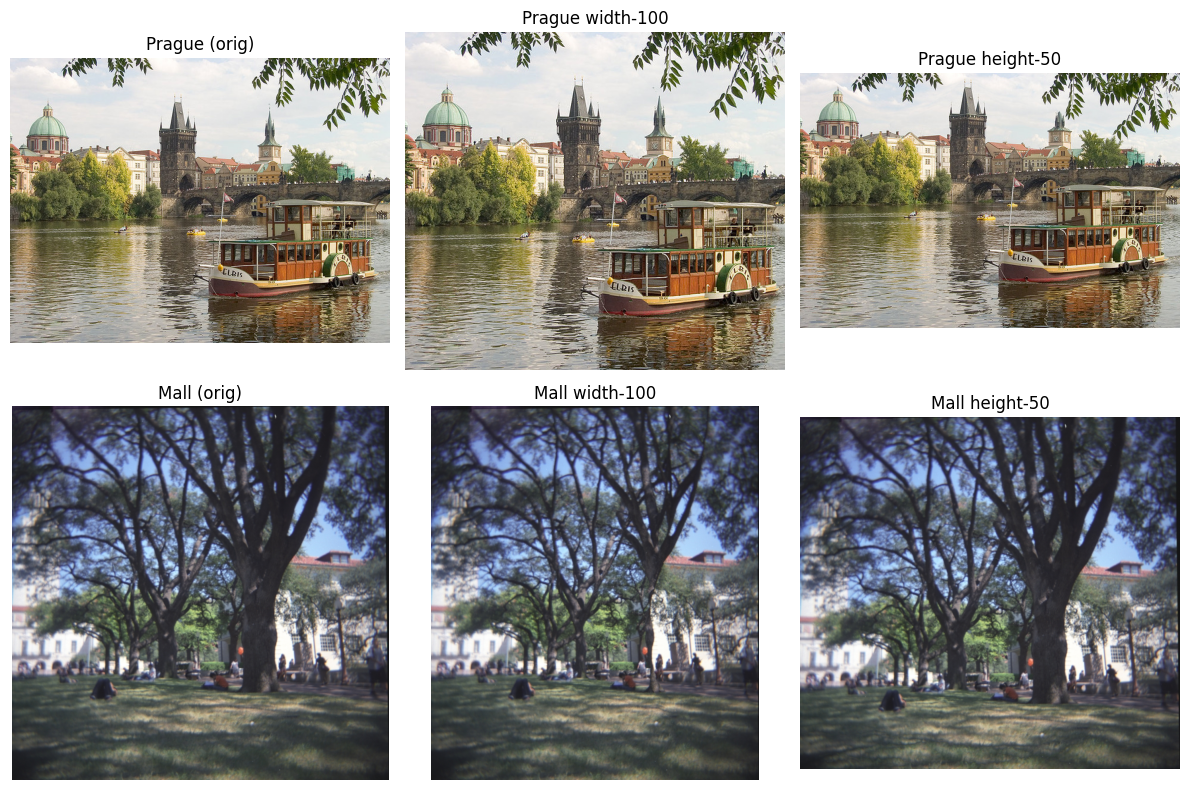

In [3]:
prague_path = 'inputSeamCarvingPrague.jpg'
mall_path   = 'inputSeamCarvingMall.jpg'
im_prague = np.array(Image.open(prague_path).convert('RGB'), dtype=np.uint8)
im_mall   = np.array(Image.open(mall_path).convert('RGB'),   dtype=np.uint8)

def reduce_width_by_100(im):
    energy = energy_img(im)
    out = im.copy()
    for _ in range(100):
        out, energy = decrease_width_baseline(out, energy)
    return out

def reduce_height_by_50(im):
    energy = energy_img(im)
    out = im.copy()
    for _ in range(50):
        out, energy = decrease_height_baseline(out, energy)
    return out

out_w_prague = reduce_width_by_100(im_prague)
out_h_prague = reduce_height_by_50(im_prague)
out_w_mall = reduce_width_by_100(im_mall)
out_h_mall = reduce_height_by_50(im_mall)

Image.fromarray(out_w_prague).save('outputReduceWidthPrague.png')
Image.fromarray(out_w_mall).save('outputReduceWidthMall.png')
Image.fromarray(out_h_prague).save('outputReduceHeightPrague.png')
Image.fromarray(out_h_mall).save('outputReduceHeightMall.png')

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs[0,0].imshow(im_prague); axs[0,0].set_title('Prague (orig)'); axs[0,0].axis('off')
axs[0,1].imshow(out_w_prague); axs[0,1].set_title('Prague width-100'); axs[0,1].axis('off')
axs[0,2].imshow(out_h_prague); axs[0,2].set_title('Prague height-50'); axs[0,2].axis('off')
axs[1,0].imshow(im_mall); axs[1,0].set_title('Mall (orig)'); axs[1,0].axis('off')
axs[1,1].imshow(out_w_mall); axs[1,1].set_title('Mall width-100'); axs[1,1].axis('off')
axs[1,2].imshow(out_h_mall); axs[1,2].set_title('Mall height-50'); axs[1,2].axis('off')
plt.tight_layout(); plt.show()


## Task 3 — Energy image + cumulative maps (Prague)

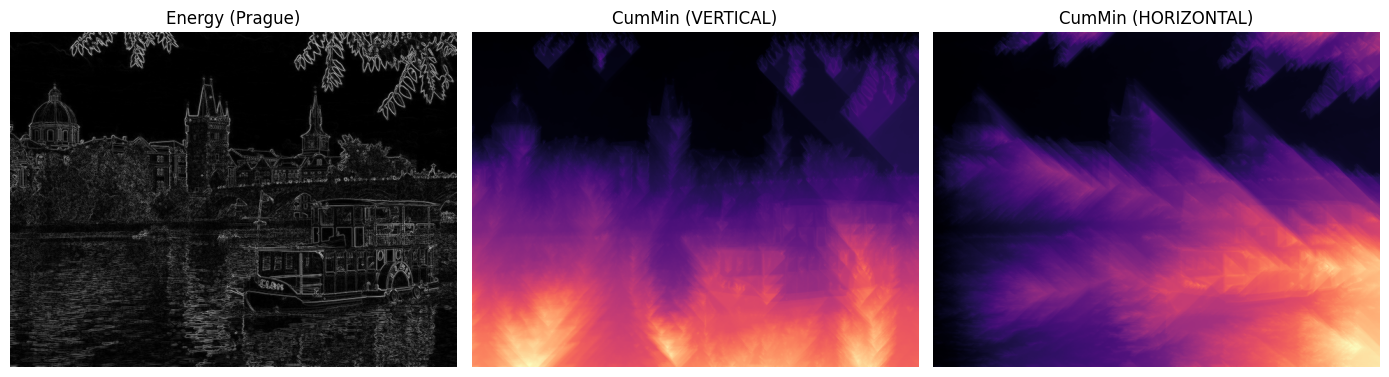

Explanation: Bright means higher accumulated cost; structures steer low-cost channels.


In [4]:
E_prague = energy_img(im_prague)
CV_prague_v = cumulative_min_energy_map(E_prague, 'VERTICAL')
CV_prague_h = cumulative_min_energy_map(E_prague, 'HORIZONTAL')

fig, axs = plt.subplots(1,3, figsize=(14,4))
axs[0].imshow(E_prague, cmap='gray'); axs[0].set_title('Energy (Prague)'); axs[0].axis('off')
axs[1].imshow(CV_prague_v, cmap='magma'); axs[1].set_title('CumMin (VERTICAL)'); axs[1].axis('off')
axs[2].imshow(CV_prague_h, cmap='magma'); axs[2].set_title('CumMin (HORIZONTAL)'); axs[2].axis('off')
plt.tight_layout(); plt.show()
print('Explanation: Bright means higher accumulated cost; structures steer low-cost channels.')


## Task 4 — Draw the first horizontal and vertical seams (Prague)

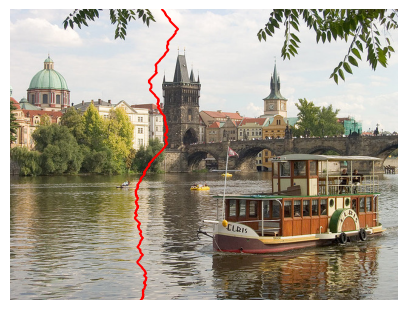

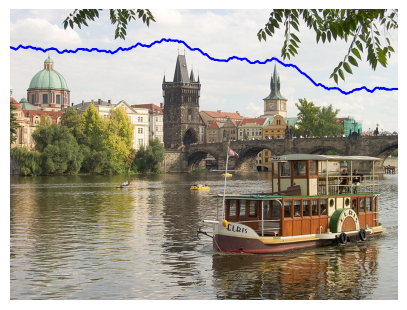

In [5]:
seam_v = find_vertical_seam(CV_prague_v)
seam_h = find_horizontal_seam(CV_prague_h)
plt.figure(figsize=(5,4)); view_seam(im_prague, seam_v, 'VERTICAL')
plt.figure(figsize=(5,4)); view_seam(im_prague, seam_h, 'HORIZONTAL')


## Task 5 — Modified energy (Prewitt + directional prior + edge penalty)

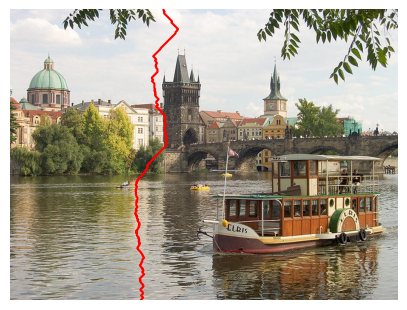

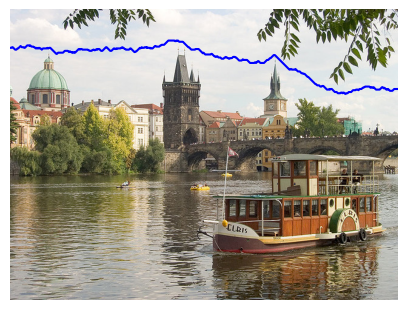

In [6]:
E_prague_mod = energy_img_prewitt_custom(im_prague, w_vert=1.25, w_horz=1.0, apply_edge_penalty=True)
CV_prague_mod_v = cumulative_min_energy_map_local(E_prague_mod, 'VERTICAL')
CV_prague_mod_h = cumulative_min_energy_map_local(E_prague_mod, 'HORIZONTAL')
seam_v_mod = _find_vertical_seam_from(CV_prague_mod_v)
seam_h_mod = _find_horizontal_seam_from(CV_prague_mod_h)
plt.figure(figsize=(5,4)); view_seam(im_prague, seam_v_mod, 'VERTICAL')
plt.figure(figsize=(5,4)); view_seam(im_prague, seam_h_mod, 'HORIZONTAL')


## Task 6 — Run on 3+ custom images vs standard resize

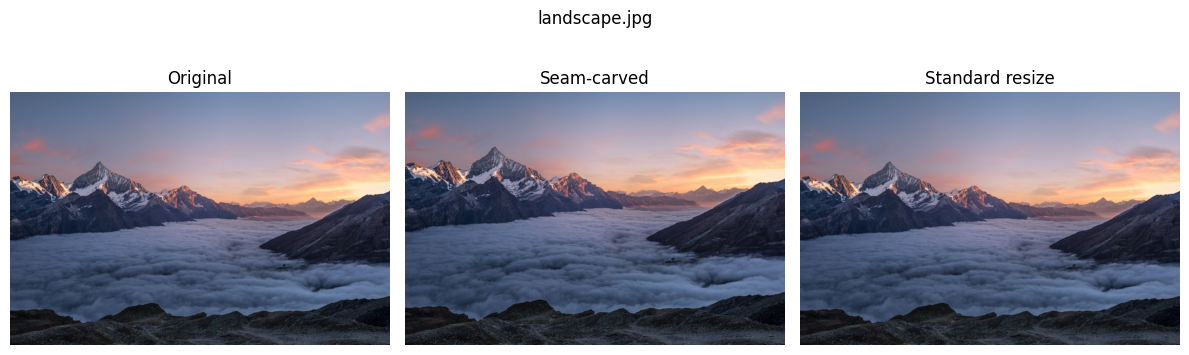

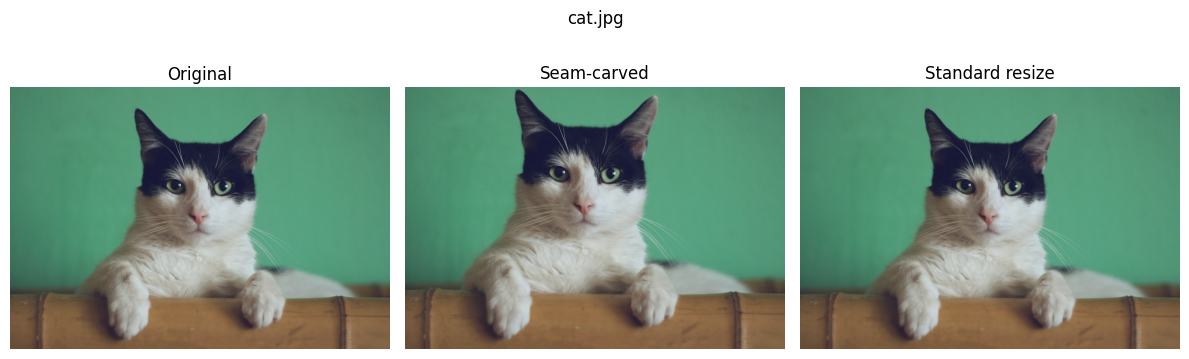

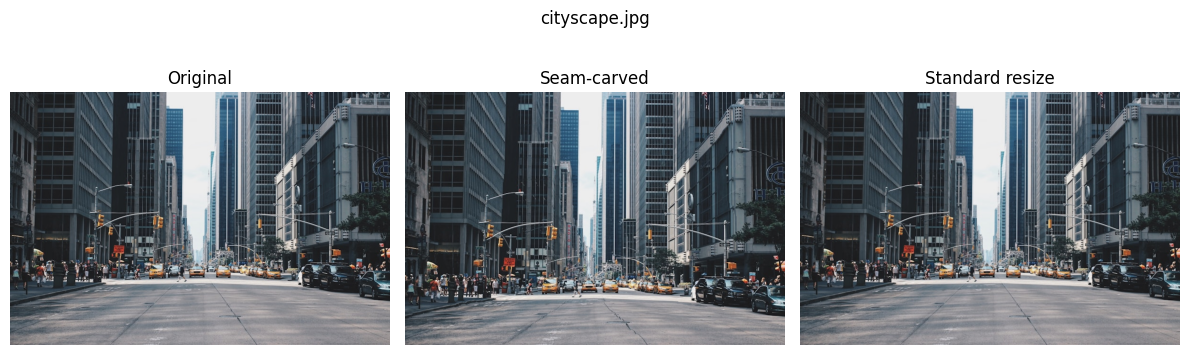

Skip my_img_1.jpg: [Errno 2] No such file or directory: 'my_img_1.jpg'
Skip my_img_2.jpg: [Errno 2] No such file or directory: 'my_img_2.jpg'
Skip my_img_3.jpg: [Errno 2] No such file or directory: 'my_img_3.jpg'


In [8]:
import urllib.request
os.makedirs('test_images', exist_ok=True)
test_urls = [
    ('https://images.unsplash.com/photo-1506905925346-21bda4d32df4', 'test_images/landscape.jpg'),
    ('https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba', 'test_images/cat.jpg'),
    ('https://images.unsplash.com/photo-1449824913935-59a10b8d2000', 'test_images/cityscape.jpg'),
]
for url, fname in test_urls:
    if not os.path.exists(fname):
        urllib.request.urlretrieve(url, fname)

custom_images = [f for _, f in test_urls]

def seam_carve_demo(img_path, dw=60, dh=40):
    try:
        im = np.array(Image.open(img_path).convert('RGB'), dtype=np.uint8)
    except Exception as e:
        print(f'Skip {img_path}: {e}')
        return
    out = im.copy(); E = energy_img(out)
    for _ in range(dw):
        out, E = decrease_width_baseline(out, E)
    for _ in range(dh):
        out, E = decrease_height_baseline(out, E)
    H, W = im.shape[:2]
    target = (W - dw, H - dh)
    std = np.array(Image.fromarray(im).resize(target, resample=Image.BICUBIC))
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(im); axs[0].set_title('Original'); axs[0].axis('off')
    axs[1].imshow(out); axs[1].set_title('Seam-carved'); axs[1].axis('off')
    axs[2].imshow(std); axs[2].set_title('Standard resize'); axs[2].axis('off')
    plt.suptitle(os.path.basename(img_path)); plt.tight_layout(); plt.show()

for p in custom_images:
    seam_carve_demo(p, dw=60, dh=40)


custom_images = ['my_img_1.jpg','my_img_2.jpg','my_img_3.jpg']

def seam_carve_demo(img_path, dw=60, dh=40):
  try:
    im = np.array(Image.open(img_path).convert('RGB'), dtype=np.uint8)
  except Exception as e:
    print(f'Skip {img_path}: {e}')
    return
  out = im.copy(); E = energy_img(out)
  for _ in range(dw):
    out, E = decrease_width_baseline(out, E)
  for _ in range(dh):
    out, E = decrease_height_baseline(out, E)
  H, W = im.shape[:2]
  target = (W - dw, H - dh)
  std = np.array(Image.fromarray(im).resize(target, resample=Image.BICUBIC))
  fig, axs = plt.subplots(1,3, figsize=(12,4))
  axs[0].imshow(im); axs[0].set_title('Original'); axs[0].axis('off')
  axs[1].imshow(out); axs[1].set_title('Seam-carved'); axs[1].axis('off')
  axs[2].imshow(std); axs[2].set_title('Standard resize'); axs[2].axis('off')
  plt.suptitle(os.path.basename(img_path)); plt.tight_layout(); plt.show()

for p in custom_images:
  seam_carve_demo(p, dw=60, dh=40)
